In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg
from tqdm import tqdm
from time import time
import transforms3d as t3d

from src.load_data import load_all_data
from src.utils import *
from src.map import MAP
from src.icp import icp as py_icp
from src.new_icp import icp as hn_icp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
dataset = 20
data = load_all_data(dataset)

__Low Pass Filtering__

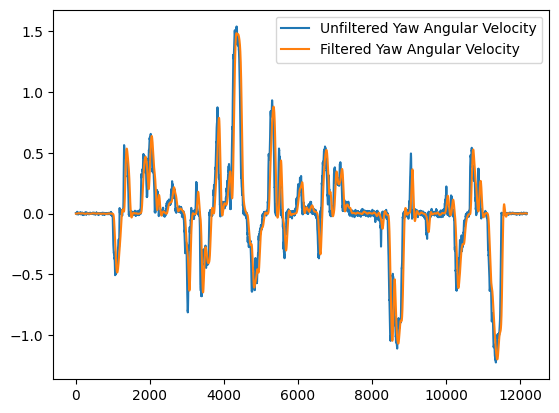

In [3]:
yaw_angular_velocity = data.imu_angular_velocity[2,:]

plt.plot(yaw_angular_velocity, label="Unfiltered Yaw Angular Velocity")
plt.plot(data.filtered_yaw_angular_velocity, label="Filtered Yaw Angular Velocity")
plt.legend()

__Linear Velocity Calculation__

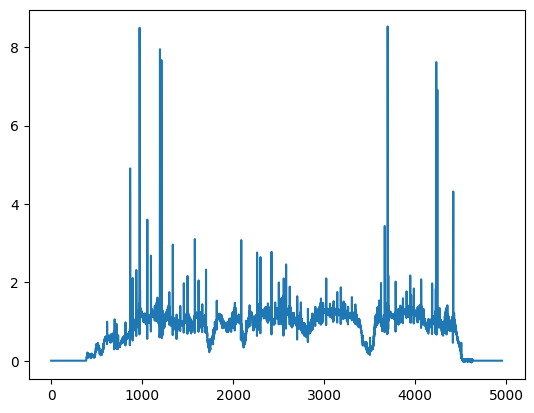

In [4]:
plt.plot(data.linear_velocity)

__LIDAR Data__

In [5]:
ALL_ANGLES = np.linspace(-135/180*np.pi, 135/180*np.pi, 1081)
def get_lidar_coordinates(ranges):

    # Get valid ranges
    # valid_index = np.logical_and(ranges <= data.lidar_range_max, ranges >= data.lidar_range_min)
    # filtered_ranges = ranges[valid_index]

    # # Get valid angles
    # angles = ALL_ANGLES[valid_index]
    filtered_ranges = ranges
    angles = ALL_ANGLES

    x = filtered_ranges * np.cos(angles)
    y = filtered_ranges * np.sin(angles)

    coords_lidar_frame = np.stack((x, y))

    return coords_lidar_frame

__Pose Approximation__

In [6]:
time_diff = np.abs(data.encoder_stamps[:, None] - data.lidar_stamps[None, :])
v_index = np.argmin(time_diff, axis=0)

time_diff = np.abs(data.imu_stamps[:, None] - data.lidar_stamps[None, :])
w_index = np.argmin(time_diff, axis=0)


In [7]:
def get_closest_velocities(data, lidar_timestamp):

    v_index = np.argmin(np.abs(data.encoder_stamps - lidar_timestamp))
    v = data.linear_velocity[v_index]

    w_index = np.argmin(np.abs(data.imu_stamps - lidar_timestamp))
    w = data.filtered_yaw_angular_velocity[w_index]

    return v, w

def get_next_pos_ort(particles, v, w, tau, noise=False):

    if noise:
        N = particles.shape[1]
        v = v + np.random.normal(0, 0.02, size=(1,N))
        w = w + np.random.normal(0, 0.002, size=(1,N))

    theta = particles[2,:]
    net_v = np.zeros_like(particles, dtype=np.float32)
    net_v[0,:] = v * np.cos(theta)
    net_v[1,:] = v * np.sin(theta)
    net_v[2,:] = w
    particles_t = particles + tau * net_v
    return particles_t

__Particle Filter__

In [8]:
def get_correlation_with_map(mp, particles, lidar_ranges_body_frame):

    # Shape 2,2,N
    # all_rotations = np.stack([get_rotation_matrix(x[2]) for x in particles.T], axis=-1)
    
    theta = particles[2,:]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    r1 = np.stack([cos_theta, -1*sin_theta]).reshape((1,2,-1))
    r2 = np.stack([sin_theta, cos_theta]).reshape((1,2,-1))
    all_rotations = np.concatenate([r1,r2], axis=0)

    
    # Shape 2, N
    all_positions = particles[0:2, :]

    # Shape N,2,2
    all_rotations = all_rotations.transpose((2,0,1))
    # Shape N,2
    all_positions = all_positions.T

    # Shape N,2,scans
    lidar_ranges_world = all_rotations @ lidar_ranges_body_frame + all_positions[:,:,None]

    correlations = mp.find_correlation_with_current_map(lidar_ranges_world)        
    return correlations

In [47]:
def generate_trajectory(data, v_index, w_index, noise=False, N=1):

    total_steps = data.lidar_stamps.shape[0]

    robot_trajectory = np.zeros((2, total_steps))
    robot_theta = np.zeros((1, total_steps))
    x = np.array([0, 0, 0])

    # The current best estimate of the particle
    x_t = np.array([0, 0, 0])

    if N == 1:
        x = x.reshape((3, 1))
        x_t = x_t.reshape((3,1))
    else:
        # Maintain n particles
        particles = np.stack([x] * N, axis=-1)
        wt = np.stack([1/N] * N, axis=-1)

    resolution = 0.01
    xmin = -15
    ymin = -15
    xmax = 30
    ymax = 30
    mp = MAP(resolution, xmin, ymin, xmax, ymax)

    pb = tqdm(range(1, total_steps))

    for tidx in pb:

        ranges = data.lidar_ranges[:, tidx]
        coords_lidar = get_lidar_coordinates(ranges)

        lidar_position_wrt_body = np.array([136.73/1000, 0]).reshape((2, 1))
        
        coords_body = coords_lidar - lidar_position_wrt_body

        # Get pose robot pose at current time
        tau = data.lidar_stamps[tidx] - data.lidar_stamps[tidx - 1]
        v = data.linear_velocity[v_index[tidx-1]]
        w = data.filtered_yaw_angular_velocity[w_index[tidx-1]]

        if N != 1:
            # Prediction step
            particles_t = get_next_pos_ort(particles, v, w, tau, noise)
            
            # Update step
            correlations = get_correlation_with_map(mp, particles_t, coords_body)
            wt = wt * np.max(correlations, axis=1)
            wt = wt / np.sum(wt)
            # pb.set_description(f"{wt}")
            
            # Resample
            Neff = 1 / np.sum(np.square(wt))
            if Neff < N/2:
                indexes = np.random.choice(list(range(N)), N, replace=True, p=wt.tolist())
                particles = particles_t[:, indexes]
            else:
                particles = particles_t

            # Choose the best particle
            idx = np.argmax(wt)
            x_t = particles_t[:, idx].reshape((3,1))
        else:
            x_t = get_next_pos_ort(x, v, w, tau)
            x = x_t

        robot_trajectory[:, tidx][:, None] = x_t[0:2, :]
        robot_theta[:, tidx] = np.arctan2(np.sin(x_t[2, :]), np.cos(x_t[2,:]))

        R = get_rotation_matrix(x_t[2, :])
        p = x_t[0:2,:]

        # Get all lidar coordinates in world frame
        coords_world = R @ coords_body + p

        # Get the occupancy map
        # if tidx % 1==0:
            # mp.update_occ_map(coords_world, p + lidar_position_wrt_body)

    return mp, robot_trajectory, robot_theta

__LIDAR SCAN MATCHING__

In [43]:
def generate_scan_match_trajectory(data):

    total_steps = data.lidar_stamps.shape[0]

    x = np.array([0, 0, 0])

    # The current best estimate of the particle
    x_t = np.array([0, 0, 0])
    T_t = np.identity(3)
    T_delta = np.identity(3)
    T_deltas = [T_delta]
    T_ts = [T_t]

    pb = tqdm(range(1, total_steps))

    for tidx in pb:

        ranges = data.lidar_ranges[:, tidx]
        coords_lidar_t = get_lidar_coordinates(ranges)

        ranges = data.lidar_ranges[:, tidx-1]
        coords_lidar_t_1 = get_lidar_coordinates(ranges)

        lidar_position_wrt_body = np.array([136.73/1000, 0]).reshape((2, 1))
        
        coords_body_t = coords_lidar_t - lidar_position_wrt_body
        coords_body_t_1 = coords_lidar_t_1 - lidar_position_wrt_body

        T_delta, _ = py_icp(coords_body_t.T, coords_body_t_1.T, init_pose=T_delta, max_iterations=20)
        T_deltas.append(T_delta)
        # T_delta, _ = hn_icp(coords_body_t.T, coords_body_t_1.T, R_initial=T_delta[:2,:2], t_initial=T_delta[:2,2])
        T_t = T_t @ T_delta
        T_ts.append(T_t)
        x_t[:2] = T_t[:2,2]
        x_t[2] = np.arccos(T_t[0,0])
        x = x_t

    robot_trajectory = list(zip(*[(x[0,2], x[1, 2]) for x in T_ts]))
    robot_theta = [np.arctan2(x[1,0], x[0,0]) for x in T_ts]

    return robot_trajectory, robot_theta, T_ts, T_deltas

__Dead Reckoning__

In [48]:
mp, robot_trajectory, robot_theta = generate_trajectory(data, v_index, w_index)

100%|██████████| 4961/4961 [00:00<00:00, 7920.58it/s] 


In [39]:
robot_trajectory_sc, robot_theta_sc, T_ts, T_deltas = generate_scan_match_trajectory(data)

100%|██████████| 4961/4961 [00:30<00:00, 162.50it/s]


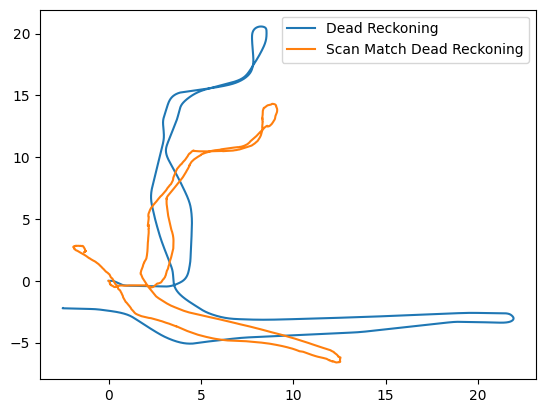

In [49]:
plt.plot(robot_trajectory[0,:], robot_trajectory[1,:], label='Dead Reckoning')
plt.plot(robot_trajectory_sc[0], robot_trajectory_sc[1], label='Scan Match Dead Reckoning')
plt.legend()

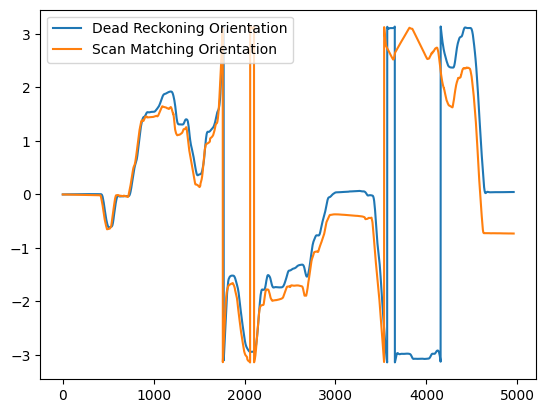

In [50]:
plt.plot(robot_theta.T, label="Dead Reckoning Orientation")
plt.plot(robot_theta_sc, label="Scan Matching Orientation")
plt.legend()

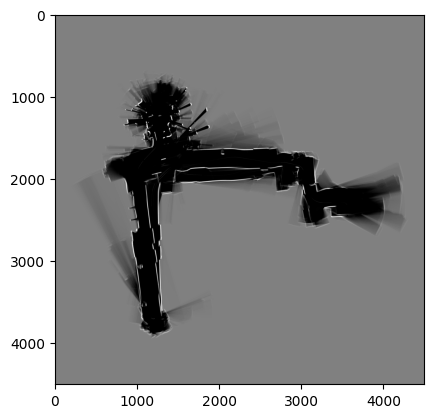

In [12]:
occupancy_map = np.copy(mp.MAP["map"])
# occupancy_map[occupancy_map > 5] = 1
# occupancy_map[occupancy_map <= 5] = 1
plt.imshow(occupancy_map, cmap='gray')
# plt.savefig("deadreckoning-occupancy-map.png")

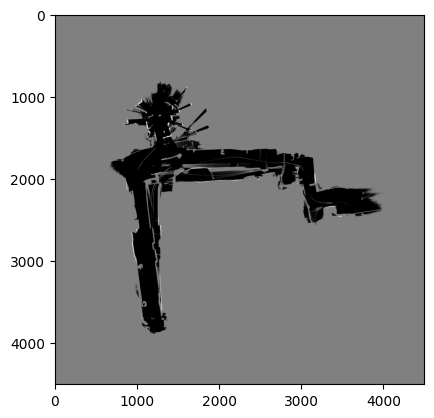

In [13]:
dmap = np.zeros_like(occupancy_map)
dmap[occupancy_map==100] = 1
dmap[occupancy_map==-100] = -1
# dmap[np.logical_and(occupancy_map!=-100, occupancy_map!=100)] = -1
plt.imshow(dmap, cmap="gray")

In [14]:
np.save("dead-occupancy-map.npy", occupancy_map)
occupancy_map.shape

(4501, 4501)

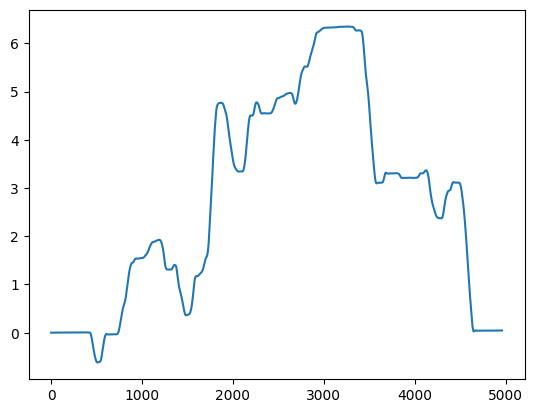

In [26]:
plt.plot(robot_theta[0,:])

In [13]:
# np.save("deadreckoning-trajectory.npy", robot_trajectory)
# np.save("deadreckoning-theta.npy", robot_theta)

__Particle Filter__

In [10]:
mp, robot_trajectory, robot_theta = generate_trajectory(data, v_index, w_index, noise=True, N=500)

100%|██████████| 4961/4961 [21:22<00:00,  3.87it/s]


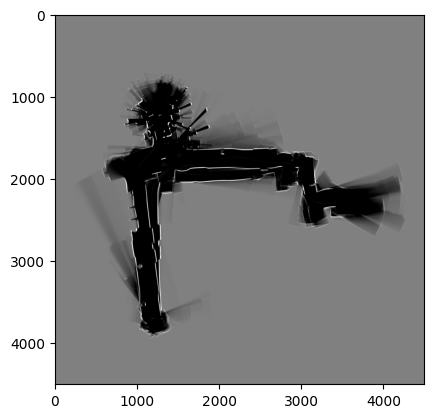

In [11]:
occupancy_map = np.copy(mp.MAP["map"])
# occupancy_map[occupancy_map > 1000*np.log(4)] = 1
plt.imshow(occupancy_map, cmap='gray')
# plt.savefig("slam-occupancy-map-0,02.png")

In [40]:
np.unique(occupancy_map)

array([-100.     ,  -99.81322,  -99.8132 , ...,   99.62627,   99.81313,
        100.     ], dtype=float32)

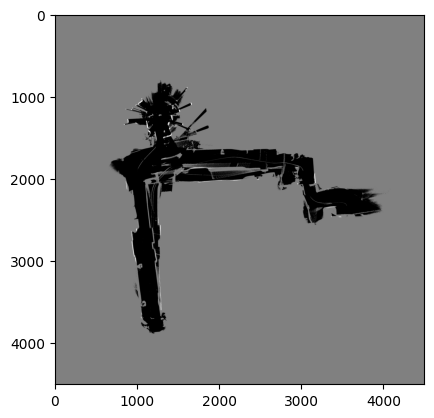

In [12]:
bmap = np.zeros_like(occupancy_map)
bmap[occupancy_map==100] = 1
bmap[occupancy_map==-100] = -1
plt.imshow(bmap, cmap='gray')

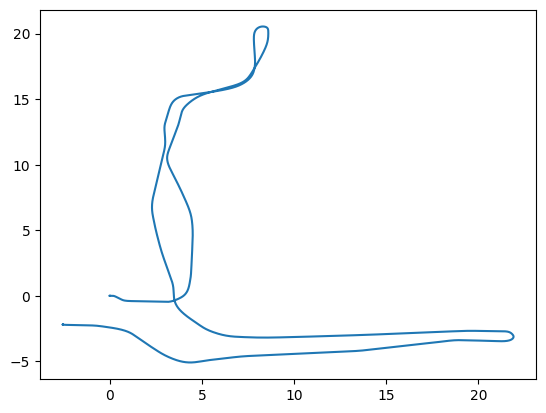

In [13]:
plt.plot(robot_trajectory[0,:], robot_trajectory[1,:])

In [33]:
np.save("slam-trajectory-0.02.npy", robot_trajectory)
np.save("slam-theta-0.02.npy", robot_theta)

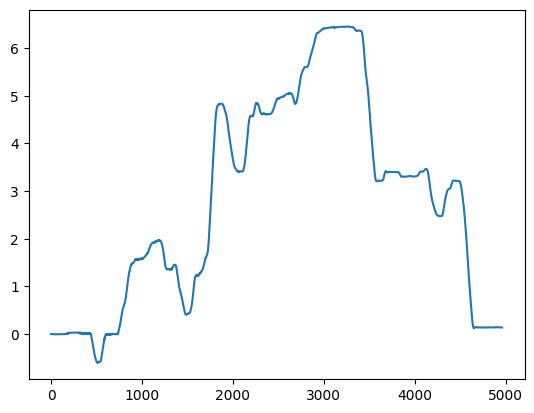

In [32]:
plt.plot(robot_theta[0,:])